In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
import ast
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import gaussian_kde

rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'


TEAL = ["#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]


In [39]:
df = pd.read_csv("../../clean_data/merged_all.csv", keep_default_na=False, na_values=[''])
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df['length'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['length'], random_state=42)
train_peps = train_df["peptide"].dropna().astype(str).tolist()

AA = list("ACDEFGHIKLMNPQRSTVWY")

In [ ]:
validation_data = pickle.load(open("cvae_evaluation_results.pkl", "rb"))
validation_data.keys()

samples_df: pd.DataFrame = validation_data["samples_df"]
novelty_df: pd.DataFrame = validation_data.get("novelty_df")
within_df:  pd.DataFrame = validation_data.get("within_df")
div_stats   = validation_data.get("diversity_stats", {})

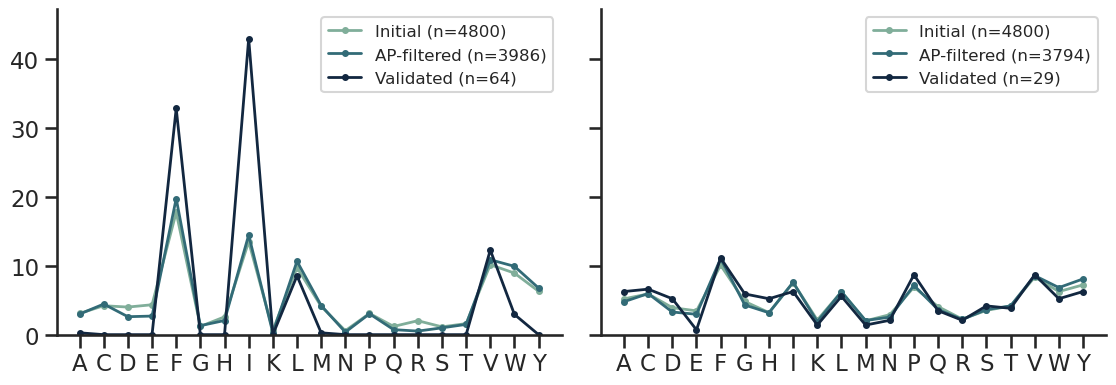

In [ ]:
sns.set(style='ticks', context='talk')

PATHS = {
    "spheres": {
        "init":    "generated_spheres_init.txt",
        "filtered": "filtered_ap_peptides_spheres.txt",
        "final":   "valid_spheres.csv"
    },
    "fibers": {
        "init":  "generated_fibers_init.txt", 
        "filtered": "filtered_ap_peptides_fiber.txt",
        "final":   "valid_fibers.csv"
    },
}

def read_init_txt(path):
    """Plain TXT: one sequence per line (e.g., 'PFQD')."""
    seqs = []
    with open(path, "r") as f:
        for line in f:
            s = line.strip().split()[0] if line.strip() else ""
            if s and not s.startswith("#"):
                seqs.append(s.upper())
    return seqs

def read_filtered_txt(path):
    """Filtered TXT: 'SEQ, human-readable, ap, prob' → take first comma-separated field."""
    seqs = []
    with open(path, "r") as f:
        for line in f:
            raw = line.strip()
            if not raw or raw.startswith("#"):
                continue
            first = raw.split(",", 1)[0].strip()
            if first:
                seqs.append(first.upper())
    return seqs

def read_final_csv(path):
    """CSV with a 'sequence' column."""
    df = pd.read_csv(path)
    col = "sequence" if "sequence" in df.columns else df.columns[0]
    return df[col].dropna().astype(str).str.upper().tolist()

def aa_freqs(seq_list, alphabet=AA):
    counts = Counter()
    total = 0
    for s in seq_list:
        for ch in s:
            if ch in alphabet:
                counts[ch] += 1
                total += 1
    if total == 0:
        return np.zeros(len(alphabet))
    return np.array([counts[a] / total for a in alphabet], dtype=float) * 100

def load_three_stages(paths):
    folder = 'gen_peptides/'
    seq_init   = read_init_txt(folder + paths["init"])
    seq_filter = read_filtered_txt(folder + paths["filtered"])
    seq_final  = read_final_csv(folder + paths["final"])

    return {
        "init":   {"seqs": seq_init,   "freq": aa_freqs(seq_init)},
        "filter": {"seqs": seq_filter, "freq": aa_freqs(seq_filter)},
        "final":  {"seqs": seq_final,  "freq": aa_freqs(seq_final)},
    }

data = {}
for morph in ["spheres", "fibers"]:
    data[morph] = load_three_stages(PATHS[morph])

global_max = 0.0
for morph in data:
    for stage in ["init", "filter", "final"]:
        global_max = max(global_max, data[morph][stage]["freq"].max())
ylim_top = max(global_max, 0.15) * 1.10

fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.2), sharey=True)
stage_style = [
    ("init",   "Initial",         TEAL[1]),
    ("filter", "AP-filtered",     TEAL[3]),
    ("final",  "Validated",       TEAL[5]),
]

for ax, morph_title in zip(axes, ["Spheres", "Fibers"]):
    D = data[morph_title.lower()]
    for key, label, color in stage_style:
        frq = D[key]["freq"]
        n   = len(D[key]["seqs"])
        ax.plot(AA, frq, marker="o", linewidth=2, markersize=4, label=f"{label} (n={n})", color=color)

    ax.set_ylim(0, ylim_top)
    sns.despine(ax=ax)
    ax.legend(frameon=True, fontsize=12)

plt.tight_layout()
plt.show()

fig.savefig("plot_aa_composition_evolution.svg", format="svg", bbox_inches="tight", dpi=300)


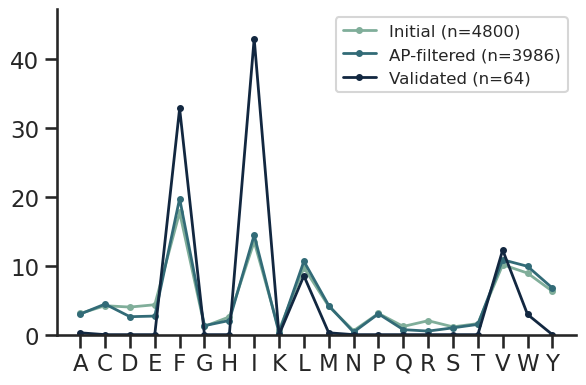

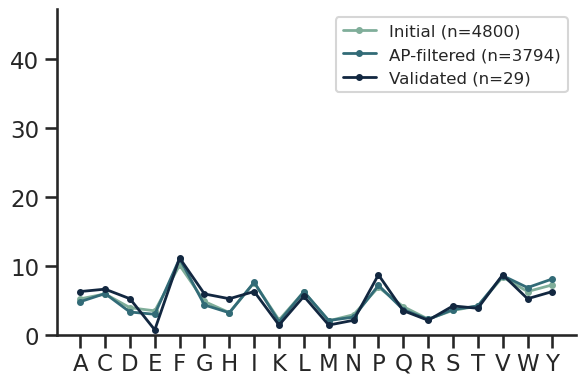

In [ ]:
stage_style = [
    ("init",   "Initial",     TEAL[1]),
    ("filter", "AP-filtered", TEAL[3]),
    ("final",  "Validated",   TEAL[5]),
]

def plot_morph(morph_key, title, savepath):
    D = data[morph_key]
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.2))
    for key, label, color in stage_style:
        frq = D[key]["freq"]
        n   = len(D[key]["seqs"])
        ax.plot(AA, frq, marker="o", linewidth=2, markersize=4,
                label=f"{label} (n={n})", color=color)

    ax.set_ylim(0, ylim_top)
    ax.set_title(title, pad=8)
    sns.despine(ax=ax)
    ax.legend(frameon=True, fontsize=12)
    plt.tight_layout()
    fig.savefig(savepath, format="svg", bbox_inches="tight", dpi=300)
    plt.show()

plot_morph("spheres", "", "plot_aa_composition_spheres.svg")
plot_morph("fibers",  "",  "plot_aa_composition_fibers.svg")


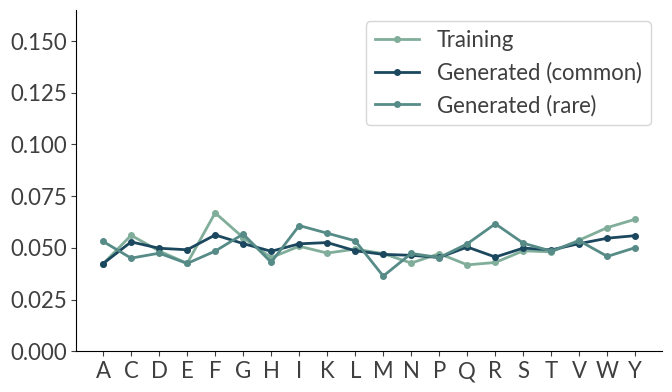

In [ ]:
def aa_freqs(seq_list):
    counts = Counter()
    total = 0
    for s in seq_list:
        for ch in s:
            if ch in AA:
                counts[ch] += 1
                total += 1
    if total == 0:
        return np.zeros(len(AA))
    return np.array([counts[a]/total for a in AA], dtype=float)

mask_in  = samples_df["ood_type"].eq("in_dist")
gen_in   = samples_df.loc[mask_in,  "sequence"].dropna().astype(str).tolist()
gen_ood  = samples_df.loc[~mask_in, "sequence"].dropna().astype(str).tolist()

f_train = aa_freqs(train_peps)
f_in    = aa_freqs(gen_in)
f_ood   = aa_freqs(gen_ood) if len(gen_ood) else None

fig, ax = plt.subplots(figsize=(7.0, 4.2))

ax.plot(AA, f_train, marker="o", linewidth=2, markersize=4, color=TEAL[1], label="Training")
ax.plot(AA, f_in,    marker="o", linewidth=2, markersize=4, color=TEAL[4], label="Generated (common)")
if f_ood is not None:
    ax.plot(AA, f_ood, marker="o", linewidth=2, markersize=4, color=TEAL[2], label="Generated (rare)")

ax.set_ylim(0, max(f_train.max(), f_in.max(), 0.15)*1.10)
sns.despine(ax=ax)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

fig.savefig("plot_aa_composition.svg", format="svg", bbox_inches="tight", dpi=300)

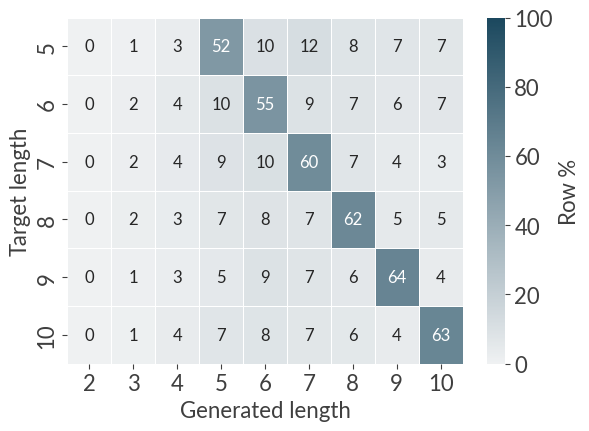

In [ ]:
mask_in = samples_df["ood_type"].eq("in_dist")
df = samples_df.loc[mask_in, ["target_length","length"]].dropna().astype(int)

cm = pd.crosstab(df["target_length"], df["length"]).sort_index(axis=0).sort_index(axis=1)
row_pct = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0) * 100

fig, ax = plt.subplots(figsize=(6.2, 4.6))
cmap = sns.light_palette(TEAL[4], as_cmap=True)
sns.heatmap(row_pct, ax=ax, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            cbar_kws={"label":"Row %"}, linewidths=0.5, linecolor="white", annot_kws={"fontsize":12})

ax.set_xlabel("Generated length")
ax.set_ylabel("Target length")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

fig.savefig("plot_length_confusion_indist.svg", format="svg", bbox_inches="tight", dpi=300)

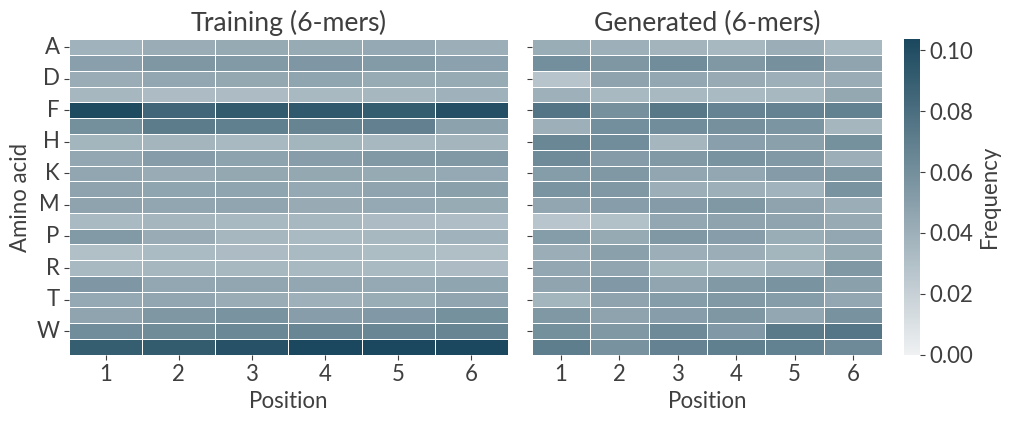

In [ ]:
AA = list("ACDEFGHIKLMNPQRSTVWY")

def pos_aa_matrix(seq_list, L=6):
    mat = pd.DataFrame(0, index=AA, columns=[f"{i+1}" for i in range(L)], dtype=float)
    ncols_counts = np.zeros(L, dtype=int)
    for s in seq_list:
        if len(s) != L: 
            continue
        for i, ch in enumerate(s):
            if ch in AA:
                mat.iloc[AA.index(ch), i] += 1
        ncols_counts += (np.arange(L) < len(s)).astype(int)
    col_sums = mat.sum(axis=0).replace(0, np.nan)
    mat = mat.div(col_sums, axis=1).fillna(0.0)
    return mat

try:
    train_peps = train_df["peptide"].dropna().astype(str).tolist()
except NameError:
    raise RuntimeError("Please provide `train_df` with a 'peptide' column in scope.")

gen6 = samples_df.loc[samples_df["length"].eq(6) & samples_df["ood_type"].eq("in_dist"), "sequence"].astype(str).tolist()
trn6 = [s for s in train_peps if len(s)==6]

mat_train = pos_aa_matrix(trn6, L=6)
mat_gen   = pos_aa_matrix(gen6, L=6)

fig, axes = plt.subplots(1, 2, figsize=(10.5, 4.5), sharey=True)
cmap = sns.light_palette(TEAL[4], as_cmap=True)

sns.heatmap(mat_train, ax=axes[0], cmap=cmap, vmin=0, vmax=mat_train.values.max()*1.0,
            cbar=False, linewidths=0.4, linecolor="white")
axes[0].set_title("Training (6-mers)", color=rcParams['text.color'])
axes[0].set_xlabel("Position"); axes[0].set_ylabel("Amino acid")

sns.heatmap(mat_gen, ax=axes[1], cmap=cmap, vmin=0, vmax=mat_train.values.max()*1.0,
            cbar_kws={"label":"Frequency"}, linewidths=0.4, linecolor="white")
axes[1].set_title("Generated (6-mers)", color=rcParams['text.color'])
axes[1].set_xlabel("Position"); axes[1].set_ylabel("")

for ax in axes: 
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

fig.savefig("plot_positional_aa_6mer.svg", format="svg", bbox_inches="tight", dpi=300)


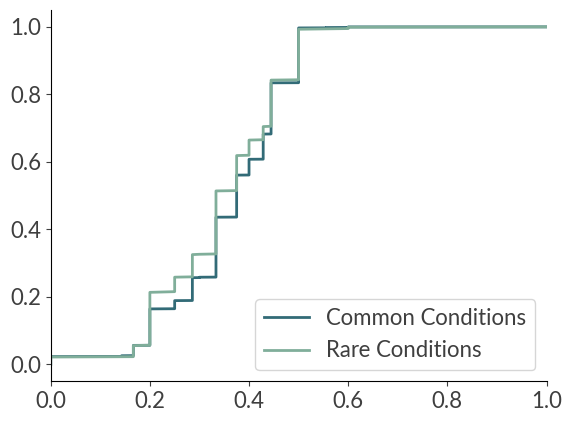

In [ ]:
if "nn_dist" not in samples_df.columns and novelty_df is not None:
    samples_df = samples_df.merge(novelty_df[["sequence","nn_dist"]], on="sequence", how="left")

def ecdf(x: np.ndarray):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

mask_in  = samples_df["ood_type"] == "in_dist"
nn_in  = samples_df.loc[mask_in, "nn_dist"].dropna().to_numpy()
nn_ood = samples_df.loc[~mask_in, "nn_dist"].dropna().to_numpy()

nn_in  = np.concatenate((nn_in,  [1.0]))
nn_ood = np.concatenate((nn_ood, [1.0])) if len(nn_ood) else np.array([1.0])

x_in,  y_in  = ecdf(nn_in)
x_ood, y_ood = ecdf(nn_ood) if len(nn_ood) else (np.array([]), np.array([]))

fig, ax = plt.subplots(figsize=(6, 4.5))

ax.plot(x_in,  y_in,  color=TEAL[3], linewidth=2, label="Common Conditions")
if len(x_ood):
    ax.plot(x_ood, y_ood, color=TEAL[1], linewidth=2, label="Rare Conditions")

sns.despine(ax=ax)
ax.legend(frameon=True)
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

fig.savefig("plot_nn_ecdf.svg", format="svg", bbox_inches="tight", dpi=300)

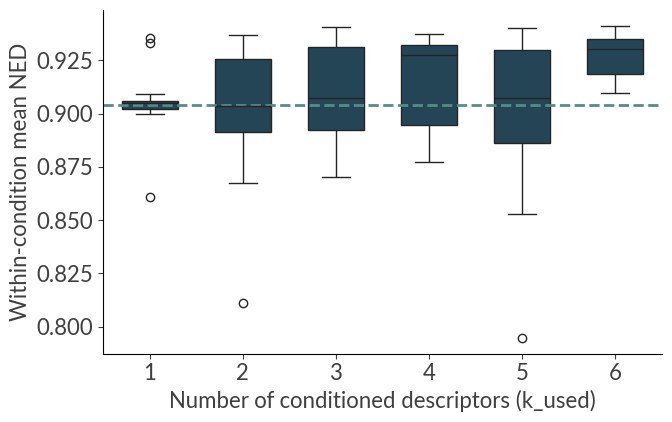

In [ ]:
k_map = samples_df.groupby("cond_idx")["used_features"].first().apply(lambda v: len(v) if isinstance(v, (list, tuple)) else np.nan)
ood_map = samples_df.groupby("cond_idx")["ood_type"].first()

plot_df = within_df.copy()
plot_df["k_used"] = plot_df["cond_idx"].map(k_map)
plot_df["ood_type"] = plot_df["cond_idx"].map(ood_map)
plot_df = plot_df[plot_df["ood_type"] == "in_dist"].dropna(subset=["k_used", "mean"])
plot_df["k_used"] = plot_df["k_used"].astype(int)

across_mean = np.nan
if isinstance(div_stats, dict) and "across_condition" in div_stats:
    across_mean = float(div_stats["across_condition"].get("mean", np.nan))

fig, ax = plt.subplots(figsize=(7, 4.5))

sns.boxplot(
    data=plot_df,
    x="k_used", y="mean",
    color=TEAL[4],
    width=0.6,
    ax=ax
)

if not np.isnan(across_mean):
    ax.axhline(across_mean, color=TEAL[2], linestyle="--", linewidth=2)

ax.set_xlabel("Number of conditioned descriptors (k_used)")
ax.set_ylabel("Within-condition mean NED")

sns.despine(ax=ax)
plt.tight_layout()
plt.show()

fig.savefig("plot_within_diversity_vs_k.svg", format="svg", bbox_inches="tight", dpi=300)


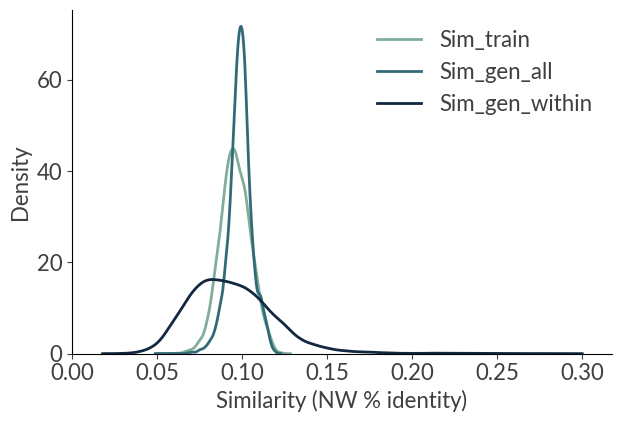

In [ ]:
needed = ["sim_train", "sim_gen_within", "sim_gen_all"]
missing = [c for c in needed if c not in samples_df.columns]
if missing:
    raise ValueError(f"Missing similarity columns in samples_df: {missing}")

sim_train   = samples_df["sim_train"].astype(float).replace([np.inf,-np.inf], np.nan).dropna().to_numpy()
sim_within  = samples_df["sim_gen_within"].astype(float).replace([np.inf,-np.inf], np.nan).dropna().to_numpy()
sim_all     = samples_df["sim_gen_all"].astype(float).replace([np.inf,-np.inf], np.nan).dropna().to_numpy()

m_train  = np.median(sim_train)  if len(sim_train)  else np.nan
m_within = np.median(sim_within) if len(sim_within) else np.nan
m_all    = np.median(sim_all)    if len(sim_all)    else np.nan

baseline_same_len   = 1.0/20.0 
baseline_len_mixed  = 0.039 

fig, ax = plt.subplots(figsize=(6.5, 4.5))

if len(sim_train):
    sns.kdeplot(sim_train,  ax=ax, color=TEAL[1], linewidth=2, label="Sim_train")
if len(sim_all):
    sns.kdeplot(sim_all,    ax=ax, color=TEAL[3], linewidth=2, label="Sim_gen_all")
if len(sim_within):
    sns.kdeplot(sim_within, ax=ax, color=TEAL[5], linewidth=2, label="Sim_gen_within")

ax.set_xlabel("Similarity (NW % identity)")
ax.set_ylabel("Density")

xmin = 0.0
xmax = max(
    (sim_train.max()  if len(sim_train)  else 0),
    (sim_within.max() if len(sim_within) else 0),
    (sim_all.max()    if len(sim_all)    else 0),
    0.2  # ensure some room
)
ax.set_xlim(xmin, min(1.0, xmax*1.1))

sns.despine(ax=ax)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

fig.savefig("plot_njirjak_similarity_kde.svg", format="svg", bbox_inches="tight", dpi=300)

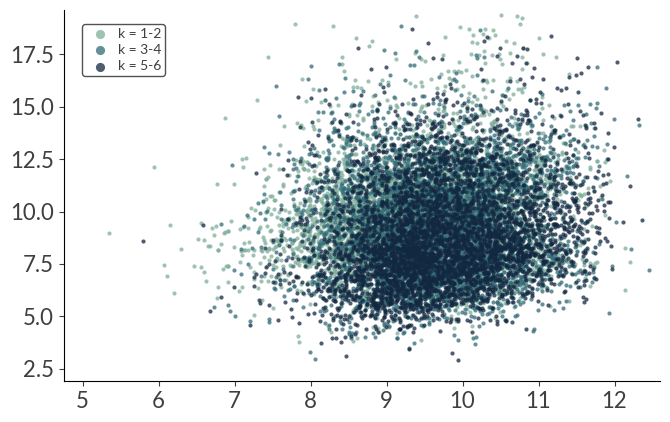

In [ ]:
needed = ["sim_train","sim_gen_within","used_features"]
missing = [c for c in needed if c not in samples_df.columns]
if missing:
    raise ValueError(f"Missing required columns for this plot: {missing}")

def to_list(v):
    if isinstance(v, (list, tuple)): return list(v)
    if isinstance(v, str):
        try: return ast.literal_eval(v)
        except Exception: return [v]
    return [v]

def k_group(k: int) -> str:
    if k <= 2:  return "k = 1-2"
    if k <= 4:  return "k = 3-4"
    return "k = 5-6"

df = samples_df.copy()
df["k_used"] = df["used_features"].apply(to_list).apply(len).astype(int)
df["k_group"] = df["k_used"].apply(k_group)

x = df["sim_train"].astype(float)
y = df["sim_gen_within"].astype(float)

group_order = ["k = 1-2", "k = 3-4", "k = 5-6"]
palette_map = {
    "k = 1-2": TEAL[1],
    "k = 3-4": TEAL[3],
    "k = 5-6": TEAL[5],
}

fig, ax = plt.subplots(figsize=(6.8, 4.5))

for g in group_order:
    sub = df[df["k_group"] == g]
    if len(sub):
        ax.scatter(sub["sim_train"] * 100, sub["sim_gen_within"] * 100,
                   s=9, alpha=0.75, linewidths=0, color=palette_map[g], label=g)


xmin = min(0.05, float(np.nanpercentile(x, 0.5)))
ymin = min(0.02, float(np.nanpercentile(y, 0.5)))
xmax = max(0.12, float(np.nanpercentile(x, 99.5)))
ymax = max(0.14, float(np.nanpercentile(y, 99.5)))
ax.set_xlim(xmin*0.95* 100, xmax*1.05* 100)
ax.set_ylim(ymin*0.95* 100, ymax*1.05* 100)

sns.despine(ax=ax)

leg = ax.legend(
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    edgecolor=rcParams['axes.labelcolor'],
    facecolor="white",
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),
    fontsize=10, 
    markerscale=2.2,
    scatterpoints=1,
    handletextpad=0.3,
    borderpad=0.25,
    labelspacing=0.3,
    columnspacing=0.6,
    ncol=1
)

plt.tight_layout()
plt.show()

fig.savefig("plot_novelty_vs_within_similarity_scatter_grouped.pdf",
            format="pdf", bbox_inches="tight", dpi=300)

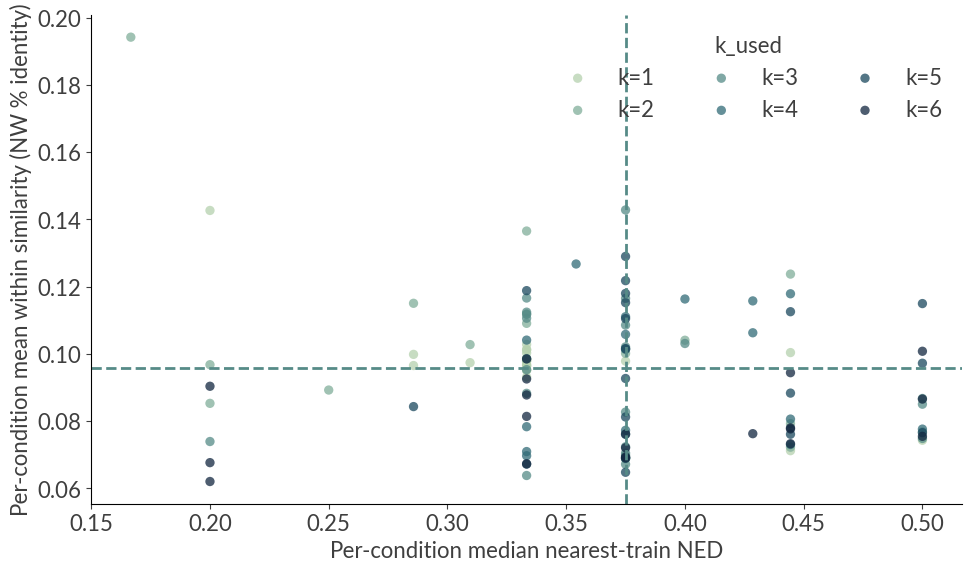

In [11]:
if "nn_dist" not in samples_df.columns and isinstance(novelty_df, pd.DataFrame):
    samples_df = samples_df.merge(novelty_df[["sequence","nn_dist"]], on="sequence", how="left")

def to_list(v):
    if isinstance(v, (list, tuple)): return list(v)
    if isinstance(v, str):
        try: return ast.literal_eval(v)
        except Exception: return [v]
    return [v]

g = samples_df.copy()
g["k_used"] = g["used_features"].apply(to_list).apply(len).astype(int)

# aggregate per condition
agg = g.groupby("cond_idx").agg(
    median_nn_dist=("nn_dist","median"),
    mean_sim_within=("sim_gen_within","mean"),
    k_used=("k_used","first"),
    ood_type=("ood_type","first"),
).reset_index()

# Colors for k=1..6 from TEAL palette
palette = {k: TEAL[min(k-1, len(TEAL)-1)] for k in sorted(agg["k_used"].unique())}

fig, ax = plt.subplots(figsize=(10, 6))

# plot in-dist and OOD with different markers
for k in sorted(agg["k_used"].unique()):
    sub_in  = agg[(agg["k_used"]==k) & (agg["ood_type"]=="in_dist")]
    sub_ood = agg[(agg["k_used"]==k) & (agg["ood_type"]!="in_dist")]
    if len(sub_in):
        ax.scatter(sub_in["median_nn_dist"], sub_in["mean_sim_within"],
                   s=45, color=palette[k], alpha=0.75, edgecolors="none", label=f"k={k}" if k not in [*ax.get_legend_handles_labels()[1]] else None, marker="o")
    if len(sub_ood):
        ax.scatter(sub_ood["median_nn_dist"], sub_ood["mean_sim_within"],
                   s=65, color=palette[k], alpha=0.95, edgecolors="black", linewidths=0.5, marker="s")

# reference medians
x_med = np.nanmedian(agg["median_nn_dist"])
y_med = np.nanmedian(agg["mean_sim_within"])
ax.axvline(x_med, color=TEAL[2], linestyle="--", linewidth=2)
ax.axhline(y_med, color=TEAL[2], linestyle="--", linewidth=2)

ax.set_xlabel("Per-condition median nearest-train NED")
ax.set_ylabel("Per-condition mean within similarity (NW % identity)")
sns.despine(ax=ax)

# Legend: k_used colors; square marker implies OOD (noted in caption)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="k_used", frameon=False, ncol=min(3, len(labels)))
plt.tight_layout()
plt.show()

fig.savefig("plot_condition_novelty_vs_within_similarity.svg", format="svg", bbox_inches="tight", dpi=300)


In [34]:
df = pd.read_csv('gen_peptides/rmoi_and_ap_by_run.csv')
df['group'] = 'all'   # single category for split violin
low_thr, high_thr = 0.35, 0.75
min_ap, max_ap = 0.959986, 2.89703

In [35]:
#drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,morphology,peptide,run,RMOI,aggregation_propensity,visual_morphology,is_target,group
0,spheres,FFIFI,run_1,0.896117,2.784343,spherical,yes,all
1,spheres,FFIFI,run_2,0.811735,2.842389,spherical,yes,all
2,spheres,FFIFI,run_3,0.815658,2.878914,spherical,yes,all
3,spheres,FFLFI,run_1,0.838104,2.742129,spherical,yes,all
4,spheres,FFLFI,run_2,0.755220,2.796964,spherical,yes,all
...,...,...,...,...,...,...,...,...
85,fibers,RAVYGDFVFL,run_2,0.411811,2.196771,sheet string-like,no,all
86,fibers,RAVYGDFVFL,run_3,0.354731,2.148178,fiber intertwined,yes,all
87,fibers,VFLVPVDFKY,run_1,0.351668,2.740966,fiber,yes,all
88,fibers,VFLVPVDFKY,run_2,0.534394,2.801216,vesicle,no,all


In [37]:
# sort by rmoi
df = df.sort_values(by='RMOI')

# display all
pd.set_option('display.max_rows', None)
df

,morphology,peptide,run,RMOI,aggregation_propensity,visual_morphology,is_target,group
62,fibers,LDIYNHPFF,run_3,0.236803,2.606587,fiber,yes,all
54,fibers,ILSCPGWPFY,run_1,0.240490,2.817635,fiber,yes,all
10,spheres,FIFVF,run_2,0.257241,2.387796,sheet,no,all
6,spheres,FIFIF,run_1,0.263922,2.336651,sheet,no,all
7,spheres,FIFIF,run_2,0.265839,2.341804,sheet,no,all
63,fibers,LFLTADSYCF,run_1,0.268675,2.504544,fiber,yes,all
64,fibers,LFLTADSYCF,run_2,0.270478,2.526214,fiber,yes,all
56,fibers,ILSCPGWPFY,run_3,0.274513,2.804190,fiber,yes,all
60,fibers,LDIYNHPFF,run_1,0.278190,2.585237,fiber,yes,all
61,fibers,LDIYNHPFF,run_2,0.279883,2.619542,fiber,yes,all


In [28]:
# each peptide has three runs (three entries)
# group by peptide, take mean of rmoi and ap, and according to is_target take majority vote for is_target
agg = df.groupby('peptide').agg(
    mean_rmoi=('RMOI', 'mean'),
    mean_ap=('aggregation_propensity', 'mean'),
    is_target=('is_target', lambda x: x.mode()[0] if not x.mode().empty else False),
    morphology=('morphology', 'first')
).reset_index()

agg

,peptide,mean_rmoi,mean_ap,is_target,morphology
0,CVSAPGIFHC,0.376627,1.959019,yes,fibers
1,FFIFI,0.841170,2.835215,yes,spheres
2,FFLFI,0.798208,2.727447,yes,spheres
3,FIFIF,0.449687,2.411279,no,spheres
4,FIFVF,0.332476,2.355055,no,spheres
5,FIVFF,0.868038,3.071661,yes,spheres
6,FIVVIF,0.818963,2.626484,yes,spheres
7,FLIFFI,0.779594,2.646630,yes,spheres
8,FTFIPGWVDL,0.398661,2.439498,yes,fibers
9,FVIFF,0.873204,3.058435,yes,spheres


In [33]:
# sort by rmoi
agg = agg.sort_values(by='mean_rmoi', ascending=False).reset_index(drop=True)
agg

,peptide,mean_rmoi,mean_ap,is_target,morphology,is_target_num
0,VFFIF,0.906594,2.902559,yes,spheres,NaN
1,FVIFF,0.873204,3.058435,yes,spheres,NaN
2,FIVFF,0.868038,3.071661,yes,spheres,NaN
3,FFIFI,0.841170,2.835215,yes,spheres,NaN
4,FVIVI,0.825284,2.153378,yes,spheres,NaN
5,FIVVIF,0.818963,2.626484,yes,spheres,NaN
6,FFLFI,0.798208,2.727447,yes,spheres,NaN
7,LIIVF,0.781477,1.983241,yes,spheres,NaN
8,FLIFFI,0.779594,2.646630,yes,spheres,NaN
9,IVFVI,0.755346,2.071813,yes,spheres,NaN


In [32]:
# do a success rate for morpholgy based on is_target being yes ('yes') or no ('no')
success_rate = agg.groupby('morphology')['is_target'].apply(lambda x: (x == 'yes').mean()).reset_index(name='success_rate')
success_rate

,morphology,success_rate
0,fibers,0.866667
1,spheres,0.800000


In [ ]:
filtered_fibers = pd.read_csv('gen_peptides/filtered_ap_peptides_fiber.txt', header=None, names=["peptide", "peptide_3", "pred_ap", "pred_clas"])
filtered_spheres = pd.read_csv('gen_peptides/filtered_ap_peptides_spheres.txt', header=None, names=["peptide", "peptide_3", "pred_ap", "pred_clas"])

def unnormalize_ap(ap):
    return (ap * (max_ap - min_ap)) + min_ap

filtered_fibers['pred_ap'] = unnormalize_ap(filtered_fibers['pred_ap'])
filtered_spheres['pred_ap'] = unnormalize_ap(filtered_spheres['pred_ap'])

combined_df = pd.concat([filtered_fibers, filtered_spheres], ignore_index=True)
combined_df

,peptide,peptide_3,pred_ap,pred_clas
0,ALWYVFPE,Ala-Leu-Trp-Tyr-Val-Phe-Pro-Glu,1.880959,0.997710
1,AVRADYVYC,Ala-Val-Arg-Ala-Asp-Tyr-Val-Tyr-Cys,1.870947,0.998530
2,VPVFLPEAIF,Val-Pro-Val-Phe-Leu-Pro-Glu-Ala-Ile-Phe,1.958868,0.999817
3,PVFDGTALHC,Pro-Val-Phe-Asp-Gly-Thr-Ala-Leu-His-Cys,1.795246,0.977304
4,KGFSYEQYC,Lys-Gly-Phe-Ser-Tyr-Glu-Gln-Tyr-Cys,1.835776,0.991674
...,...,...,...,...
7775,FCII,Phe-Cys-Ile-Ile,2.148993,0.999893
7776,FWAQMIV,Phe-Trp-Ala-Gln-Met-Ile-Val,2.022415,0.999676
7777,FMFIDW,Phe-Met-Phe-Ile-Asp-Trp,2.156174,0.999998
7778,LWVLFIF,Leu-Trp-Val-Leu-Phe-Ile-Phe,2.185822,0.999999


In [17]:
# merge df with combined_df on 'peptide', keeping pred_ap and pred_clas from combined_df
df = df.merge(combined_df[['peptide', 'pred_ap', 'pred_clas']], on='peptide', how='left')

df

,morphology,peptide,run,RMOI,aggregation_propensity,group,pred_ap,pred_clas
0,spheres,FFIFI,run_1,0.896117,2.784343,all,2.245837,0.999999
1,spheres,FFIFI,run_2,0.811735,2.842389,all,2.245837,0.999999
2,spheres,FFIFI,run_3,0.815658,2.878914,all,2.245837,0.999999
3,spheres,FFLFI,run_1,0.838104,2.742129,all,2.263951,1.000000
4,spheres,FFLFI,run_2,0.755220,2.796964,all,2.263951,1.000000
...,...,...,...,...,...,...,...,...
85,fibers,RAVYGDFVFL,run_2,0.411811,2.196771,all,1.908686,0.999409
86,fibers,RAVYGDFVFL,run_3,0.354731,2.148178,all,1.908686,0.999409
87,fibers,VFLVPVDFKY,run_1,0.351668,2.740966,all,2.078700,0.999988
88,fibers,VFLVPVDFKY,run_2,0.534394,2.801216,all,2.078700,0.999988


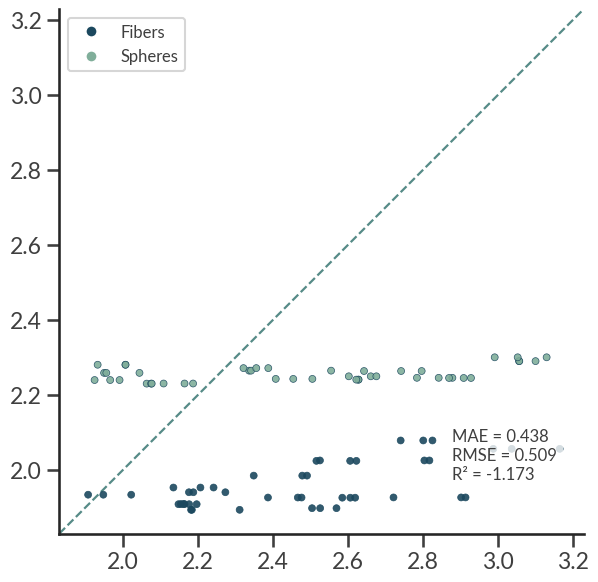

In [ ]:
sns.set(style='ticks', context='talk')


rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'

POINT = TEAL[4]
LINE = TEAL[2]

d = df[['aggregation_propensity', 'pred_ap']].dropna()
x = d['aggregation_propensity'].to_numpy(dtype=float)
y = d['pred_ap'].to_numpy(dtype=float)

res = y - x
mae  = np.mean(np.abs(res))
rmse = np.sqrt(np.mean(res**2))
ss_res = np.sum((y - x)**2)
ss_tot = np.sum((x - x.mean())**2)
r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

lo = min(x.min(), y.min())
hi = max(x.max(), y.max())
pad = 0.05 * (hi - lo if hi > lo else 1.0)
lims = (lo - pad, hi + pad)

fig, ax = plt.subplots(figsize=(6.2, 6.2))

ax.scatter(x, y, s=25, alpha=0.9, edgecolors=POINT, linewidths=0.5,
           color=[POINT if cl == 'fibers' else TEAL[1] for cl in df['morphology']],
           zorder=2)

ax.plot(lims, lims, linestyle='--', color=LINE, linewidth=1.6, zorder=1)

ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_aspect('equal', adjustable='box')

ax.grid(False)
sns.despine(ax=ax)

txt = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
ax.text(0.75, 0.2, txt, transform=ax.transAxes,
        ha='left', va='top', fontsize=12,
        bbox=dict(boxstyle='round,pad=0.35', fc='white', ec='none', alpha=0.8))

ax.legend(
        handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=POINT, markersize=8, label='Fibers'),
                 plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=TEAL[1], markersize=8, label='Spheres')],
        loc='upper left', frameon=True, fontsize=12,
        )

plt.tight_layout()
plt.show()
fig.savefig('ap_vs_predap.svg', format='svg', bbox_inches='tight', dpi=300)
plt.close(fig)


/tmp/ipykernel_947693/2745591621.py:20: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


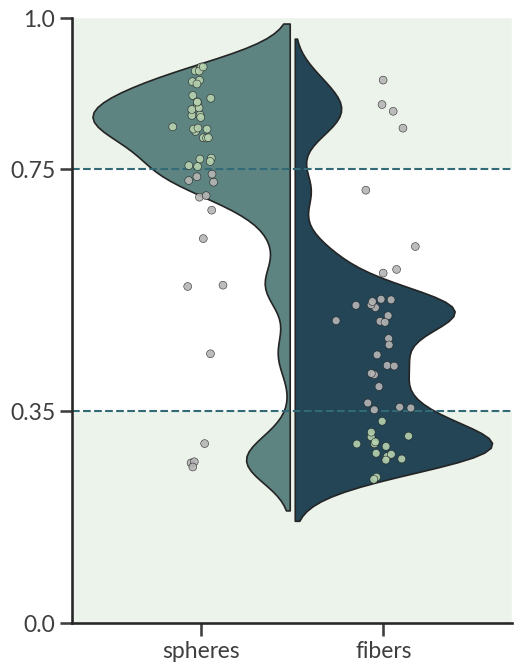

In [ ]:
PALETTE = {'spheres': TEAL[2], 'fibers': TEAL[4]}
LINE = TEAL[3]
FILL_LOW, FILL_HIGH = TEAL[0], TEAL[0]
GOOD, BAD = TEAL[0], '#B5B5B5'

sns.set(style='ticks', context='talk')


rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'

fig, ax = plt.subplots(figsize=(5.5, 7))

sns.violinplot(
    x='group', y='RMOI', hue='morphology', data=df,
    split=True, inner=None, palette=PALETTE,
    bw=0.2, linewidth=1.2, gap=0.025, ax=ax
)
ax.get_legend().remove()

ax.set_ylim(0.0, 1)
ax.axhline(low_thr,  color=LINE, linestyle='--', linewidth=1.5, zorder=1)
ax.axhline(high_thr, color=LINE, linestyle='--', linewidth=1.5, zorder=1)
ax.axhspan(0.0,       low_thr,  facecolor=FILL_LOW,  alpha=0.25, zorder=0)
ax.axhspan(high_thr,  1.0,      facecolor=FILL_HIGH, alpha=0.25, zorder=0)

center = ax.get_xticks()[0]
offset = 0.18
for morph, sign in [('spheres', -1), ('fibers', +1)]:
    sub = df.loc[df['morphology'] == morph, 'RMOI'].values
    xs = np.random.normal(loc=center + sign*offset, scale=0.025, size=len(sub))
    if morph == 'spheres':
        cols = [GOOD if y > high_thr else BAD for y in sub]
    else:
        cols = [GOOD if y < low_thr  else BAD for y in sub]
    ax.scatter(xs, sub, c=cols, edgecolor='k', linewidth=0.4,
               alpha=0.9, s=32, zorder=2)

# 4) cosmetics to match paper (no axis labels, clean spine)
ax.set_xticks([center - offset, center + offset])
ax.set_xticklabels(['spheres', 'fibers'])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([0, low_thr, high_thr, 1.0])
ax.set_yticklabels(['0.0', f'{low_thr:.2f}', f'{high_thr:.2f}', '1.0'])
ax.grid(False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()
fig.savefig('rmoi_split_violin.svg', format='svg', bbox_inches='tight', dpi=300)
plt.close(fig)


In [ ]:
agg_sph = df.loc[df['morphology']=='spheres', 'aggregation_propensity'].dropna().values
agg_fib = df.loc[df['morphology']=='fibers',  'aggregation_propensity'].dropna().values

x = np.linspace(1.0, 4.0, 400)
kde_sph = gaussian_kde(agg_sph, bw_method='scott')
kde_fib = gaussian_kde(agg_fib, bw_method='scott')

sns.set(style='ticks', context='talk')

rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'
fig, ax = plt.subplots(figsize=(5.5, 4.0))

y_s = kde_sph(x)
y_f = kde_fib(x)
ax.plot(x, y_s, color=TEAL[2], linewidth=2.2, linestyle='--', label='spheres')
ax.fill_between(x, y_s, alpha=0.18, color=TEAL[2])
ax.plot(x, y_f, color=TEAL[4], linewidth=2.2, linestyle='--',  label='fibers')
ax.fill_between(x, y_f, alpha=0.25, color=TEAL[4])

ax.axvline(1.8, color=TEAL[2], linestyle='--', linewidth=2)

jitter = 0.003
ax.scatter(agg_sph, np.random.uniform(-jitter, jitter, len(agg_sph)),
           color=TEAL[4], edgecolor='k', linewidth=0.4, s=28, alpha=0.9, zorder=3)
ax.scatter(agg_fib, np.random.uniform(-jitter, jitter, len(agg_fib)),
           color=TEAL[2], edgecolor='k', linewidth=0.4, s=28, alpha=0.7, zorder=3)

ax.set_xlim(1.0, 4.0)
ax.set_xticks([1.0, 2.0, 3.0, 4.0])
ax.set_xlabel("")
ax.set_ylabel("")
leg = ax.legend(frameon=False, loc='upper left', fontsize=11)
ax.grid(False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()
fig.savefig('aggregation_propensity_kde.svg', format='svg', bbox_inches='tight', dpi=300)
plt.close(fig)
